<a href="https://colab.research.google.com/github/lightuse/AML/blob/master/Automated_Machine_Learning_Binary_Classification_by_lale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install lale[full]
!pip install lale

In [ ]:
from common import function

# supervised learning
## binary classification

Setting

In [ ]:
# set pipelines for different algorithms
from sklearn.pipeline import Pipeline
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
evaluation_list = {'AUC':'roc_auc',
                   'F1':'f1',
                   'Recall':'recall',
                   'Precision':'precision',
                   'Accuracy':'accuracy'}
evaluation_function_list = {'AUC':roc_auc_score,
                            'F1':f1_score,
                            'Recall':recall_score,
                            'Precision':precision_score,
                            'Accuracy':accuracy_score}
options_evaluation = [ 'Accuracy', 'AUC', 'F1', 'Recall', 'Precision']
options_algorithm = ['knn', 'logistic', 'rsvc', 'tree', 'rf', 'gb', 'mlp', 'lightgbm', 'xgboost']
options_algorithm = ['lightgbm', 'xgboost', 'catboost', 'rsvc', 'logistic', 'rf', 'gb', 'mlp']
#options_algorithm = ['lightgbm', 'rsvc', 'mlp', 'gb', 'xgboost','catboost']
#options_algorithm = ['rf', 'gb', 'lightgbm', 'xgboost', 'mlp', 'rsvc']
# 出力を predict_proba にするか 
is_predict_proba = False
# 
is_one_hot_encoding = True
is_imputation = False
exception_algorithm_list = ['tree', 'knn', 'xgboost', 'logistic', 'rsvc', 'rf', 'gb', 'mlp', 'catboost']
exception_algorithm_list = ['tree', 'knn', 'rsvc', 'gb', 'mlp', 'xgboost', 'catboost']
pipelines = {
    'lightgbm':
        Pipeline([('pca', PCA(random_state=1)),
                  #('est', lgb.LGBMClassifier(random_state=1, learning_rate=0.1, max_depth=16, n_estimators=1000, num_leaves=31))]),
                  ('est', lgb.LGBMClassifier(random_state=1))]),
    'xgboost':
        Pipeline([('pca', PCA(random_state=1)),
                  ('est', xgb.XGBClassifier(random_state=1))]),
    'catboost':
        Pipeline([('pca', PCA(random_state=1)),
                  ('est', CatBoostClassifier(random_state=1))]),
    'knn':
        Pipeline([('scl', StandardScaler()),
                  ('pca', PCA(random_state=1)),
                  ('est', KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))]),
    'logistic':
        Pipeline([('scl', StandardScaler()),
                  ('pca', PCA(random_state=1)),
                  ('est', LogisticRegression(random_state=1))]),
    'rsvc':
        Pipeline([('scl', StandardScaler()),
                  ('pca', PCA(random_state=1)),
                  ('est', SVC(C=1.0, kernel='rbf', class_weight='balanced', probability=is_predict_proba, random_state=1))]),
    'tree':
        Pipeline([('pca', PCA(random_state=1)),
                  ('est', DecisionTreeClassifier(random_state=1))]),
    'rf':
        Pipeline([('pca', PCA(random_state=1)),
                  ('est', RandomForestClassifier(random_state=1))]),
    'gb':
        Pipeline([('pca', PCA(random_state=1)),
                  ('est', GradientBoostingClassifier(random_state=1))]),
    'mlp':
        Pipeline([('scl', StandardScaler()),
                  ('pca', PCA(random_state=1)),
                  ('est', MLPClassifier(hidden_layer_sizes=(3,3), max_iter=10000, random_state=1))])
}

for algorithm in exception_algorithm_list:
    if algorithm in pipelines:
        pipelines.pop(algorithm)

In [ ]:
# 表示オプションの変更
import pandas as pd
pd.set_option('display.max_rows', 100)
# カテゴリ変数をリストで設定
ohe_columns = ['lobby-mode',
               'mode',
               'stage',
               'A1-weapon',
               'A1-rank',
               'A2-weapon',
               'A2-rank',
               'A3-weapon',
               'A3-rank',
               'A4-weapon',
               'A4-rank',
               'B1-weapon',
               'B1-rank',
               'B2-weapon',
               'B2-rank',
               'B3-weapon',
               'B3-rank',
               'B4-weapon',
               'B4-rank',
            ]
# カテゴリ変数をobject型で読み込むための準備
my_dtype = {'game-ver':object,
               'lobby-mode':object,
               'lobby':object,
               'mode':object,
               'stage':object,
               'A1-weapon':object,
               'A1-rank':object,
               'A2-weapon':object,
               'A2-rank':object,
               'A3-weapon':object,
               'A3-rank':object,
               'A4-weapon':object,
               'A4-rank':object,
               'B1-weapon':object,
               'B1-rank':object,
               'B2-weapon':object,
               'B2-rank':object,
               'B3-weapon':object,
               'B3-rank':object,
               'B4-weapon':object,
               'B4-rank':object,
               'A1-level':float,
               'A2-level':float,
               'A3-level':float,
               'A4-level':float,
               'B1-level':float,
               'B2-level':float,
               'B3-level':float,
               'B4-level':float,
            }
id_label = ['id']
target_label = ['y']
drop_columns = ['game-ver', 'lobby']
train_file_name = out_put_data_dir + 'train_data.csv'
test_file_name = out_put_data_dir + 'test_data.csv'
model_columns_file_name = out_put_data_dir + 'model_columns.csv'
# feature_selection range 50-150
n_features_to_select = 200
# ファイル出力拡張子
file_extention = 'csv'

In [ ]:
# ホールドアウト有無
is_holdout = False
# k-fold 法を利用するか
is_k_fold = True
is_optuna = False
is_header = True

In [ ]:
def input_train_file(filename, my_dtype):
    df = pd.read_csv(train_file_name, header=0, dtype=my_dtype)
    # データの形式に合わせて適時修正
    df = df.drop(id_label, axis=1)
    y = df.iloc[:,-1]
    y.to_csv(out_put_data_dir + 'y.csv')
    class_mapping = {0:0, 1:1}
    y = y.map(class_mapping)
    X = df.drop(target_label, axis=1)
    X = X.reset_index(drop=True)
    X.to_csv(out_put_data_dir + 'X.csv')
    print('欠損個数（数値変数の欠損補完前）:input_train_file', X.isnull().sum().sum())
    return X, y

In [ ]:
import pandas as pd
import datetime as dt
import re
import numpy as np
def transform_data(X:pd.core.series.Series):
    X['period'] =  pd.to_datetime(X['period']).map(pd.Timestamp.to_julian_date)
    publishedAt = pd.to_datetime(X['period'], utc=True)
    X["year"] = publishedAt.apply(lambda x: x.year)
    X["month"] = publishedAt.apply(lambda x: x.month)
    X["day"] = publishedAt.apply(lambda x: x.day)
    X["week"] = publishedAt.apply(lambda x: x.weekday())
    for column in ohe_columns:
        X['frequency_encode_' + column] = function.convert_to_frequency_encode(X, column)
        #X['label_encode_' + column] = function.convert_to_label_encode(X, column)
        X['count_encode_' + column] = function.convert_to_count_encode(X, column)
        X['label_count_encode_' + column] = function.convert_to_label_count_encode(X, column)

    # 不要カラム削除
    for column in drop_columns:
        X = X.drop(column, axis=1)
    X = X.reset_index(drop=True)
    return X

Modeling

In [ ]:
def train_model(out_put_data_dir, X, y, X_ohe_columns, evaluation):
    X_train, X_valid, y_train, y_valid = X, X, y, y
    import warnings
    warnings.filterwarnings("ignore")
    from lale.lib.lale import NoOp
    from lale.lib.sklearn import KNeighborsClassifier
    from lale.lib.sklearn import LogisticRegression
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from lale.lib.sklearn import Nystroem
    from lale.lib.sklearn import PCA
    from sklearn.preprocessing import Normalizer as Norm
    from sklearn.preprocessing import StandardScaler as Scale
    from lale.operators import make_union, make_choice, make_pipeline
    kernel_tfm_or_not =  Scale | NoOp | Nystroem | Norm
    kernel_tfm_or_not.visualize()
    tfm = PCA
    #clf = make_choice(LogisticRegression, XGBClassifier, LGBMClassifier)
    clf = make_choice(LogisticRegression)
    clf.visualize()
    optimizable = kernel_tfm_or_not >> tfm >> clf
    optimizable.visualize()
    from lale.lib.lale import Hyperopt
    hpo_trainable = Hyperopt(estimator=optimizable, max_evals=5)
    hpo_trained = hpo_trainable.fit(X_train, y_train)
    best_estimator = hpo_trained.get_pipeline()
    best_estimator.visualize()
    dump(best_estimator, out_put_data_dir + 'mixed' + '_classiffier.joblib')
    return X_train, X_valid, y_train, y_valid

Scoring

In [ ]:
from joblib import load
def scoring(algorithm_name :str, X, input_evaluation, is_predict_proba = False):
    clf = load(out_put_data_dir + algorithm_name + '_classiffier.joblib')
    print(algorithm_name)
    if is_optuna:
        if input_evaluation.value == 'Accuracy':
            return clf.predict(X).round()
        return clf.predict(X)
    if is_predict_proba:
        return clf.predict_proba(X)[:, 1]
    return clf.predict(X)

In [ ]:
def evaluation(scores, X_train, y_train, text, evaluation_function_list, input_evaluation, is_predict_proba):
    print(input_evaluation.value)
    #for pipe_name, pipeline in pipelines.items():     
    scores[('mixed', text)] = evaluation_function_list[input_evaluation.value](y_train, scoring('mixed', X_train, input_evaluation, is_predict_proba))

In [ ]:
input_evaluation = function.choice(options_evaluation)

RadioButtons(options=('Accuracy', 'AUC', 'F1', 'Recall', 'Precision'), value='Accuracy')

In [ ]:
X, y = input_train_file(train_file_name, my_dtype)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



欠損個数（数値変数の欠損補完前）:input_train_file 115890


In [ ]:
X = transform_data(X)

In [ ]:
X_ohe = function.one_hot_encoding(X, ohe_columns)
X_ohe.to_csv(out_put_data_dir + "X_ohe.csv", index=False, header=True)
#pd.DataFrame(X_ohe).to_csv(out_put_data_dir + "X_ohe.csv", index=False)
print('欠損個数（数値変数の欠損補完前）', X_ohe.isnull().sum().sum())
print('')
print(X_ohe.isnull().sum())
X_ohe, X_ohe_columns = function.imputation(out_put_data_dir, model_columns_file_name, X_ohe)

欠損個数（数値変数の欠損補完前） 115890

period          0
A1-level        0
A2-level        0
A3-level        0
A4-level       51
               ..
B4-rank_c-      0
B4-rank_s       0
B4-rank_s+      0
B4-rank_x       0
B4-rank_nan     0
Length: 1327, dtype: int64


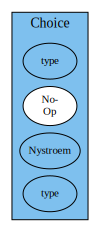

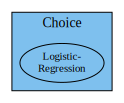

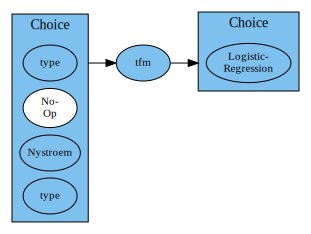

simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': 'l2'}' has unknown type
simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': True}' has unknown type
simplifyAll: '{'default': 'l2'}' has unknown type
simplifyAll: '{'default': True}' has unknown type


100%|██████████| 5/5 [32:13<00:00, 386.70s/trial, best loss: -0.5321739130434782]


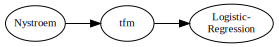

In [ ]:
# train
X_train, X_valid, y_train, y_valid = train_model(out_put_data_dir, X_ohe, y, X_ohe_columns, input_evaluation.value)

CV Score

In [ ]:
#import optuna.integration.lightgbm as lgb_tuner
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_val_predict
#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
str_all_print = 'n_features_to_select:' + str(n_features_to_select) + '\n'
if is_k_fold:
    print('評価指標:' + input_evaluation.value)
    str_print = ''
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    #kf = StratifiedKFold(shuffle=True, random_state=0)
    clf = load(out_put_data_dir + 'mixed' + '_classiffier.joblib')
    cv_results = cross_val_score(clf,
                                X_ohe, y,
                                cv=kf,
                                scoring=evaluation_list[input_evaluation.value])  
    str_print = '----------' + '\n' + 'algorithm:' + str('mixed') + '\n' + 'cv_results:' + str(cv_results) + '\n' + 'avg +- std_dev ' + str(cv_results.mean()) + '+-' + str(cv_results.std()) + '\n'
    print(str_print)
    str_all_print += str_print
    import datetime
    with open(out_put_data_dir + 'cv_results' + '_' + datetime.datetime.now().strftime('%Y%m%d%H%M%S') + '.txt', mode='w') as f:
        f.write(str_all_print)

評価指標:Accuracy
----------
algorithm:mixed
cv_results:[0.53565217 0.53761815 0.53141777 0.53678639 0.53534972]
avg +- std_dev 0.5353648393194707+-0.0021335582110909427



In [ ]:
scores = {}
if is_holdout:
    evaluation(scores, X_train, y_train, 'train', evaluation_function_list, input_evaluation, is_predict_proba)
    evaluation(scores, X_valid, y_valid, 'valid', evaluation_function_list, input_evaluation, is_predict_proba)
else:
    evaluation(scores, X_train, y_train, 'train', evaluation_function_list, input_evaluation, is_predict_proba)
# sort score
#sorted_score = sorted(scores.items(), key=lambda x:-x[1])
print('評価指標:' + input_evaluation.value)
if is_holdout:
    display(pd.Series(scores).unstack().sort_values(by=['train', 'valid']))
else:
    display(pd.Series(scores).unstack().sort_values(by=['train']))

Accuracy
mixed
評価指標:Accuracy


,train
mixed,0.535365


In [ ]:
def input_test_file(filename, my_dtype, id_label):
    df_s = pd.read_csv(filename, header=0, dtype=my_dtype)
    display(df_s.head())
    X_s  = df_s.drop(id_label, axis=1)
    df_s = df_s.reset_index(drop=True)
    return df_s, X_s

In [ ]:
import datetime
def output_file(output_data_dir, n_features_to_select, target_label, df, id_label, y, model_name, extension, header=True):
    publish_file_name = output_data_dir + "submission_" + model_name + "_" + str(n_features_to_select) + "_" +  datetime.datetime.now().strftime('%Y%m%d%H%M%S') + "." + extension
    file_name = output_data_dir + "submission_" + model_name + "." + extension
    separator = ','
    df_output = pd.concat([df[id_label], pd.DataFrame(y, columns=target_label)], axis=1)
    df_output.to_csv(publish_file_name, index=False, sep=separator, header=header)
    df_output.to_csv(file_name, index=False, sep=separator, header=header)

In [ ]:
input_algorithm = function.choice(options_algorithm)

RadioButtons(options=('lightgbm', 'xgboost', 'catboost', 'rsvc', 'logistic', 'rf', 'gb', 'mlp'), value='lightg…

In [ ]:
import datetime
# 永続化したデータ読込し、 同じ評価指標ではtrain_modelは一度のみ実行で、かつ、選択されたモデルでスコアリングする
def main():
    algorithm_name = 'mixed'
    df_s, X_s = input_test_file(test_file_name, my_dtype, id_label)
    X_s = transform_data(X_s)
    X_ohe_s = function.one_hot_encoding(X_s, ohe_columns)
    X_predicted = function.preprocessing2(out_put_data_dir, model_columns_file_name, algorithm_name, X_ohe, X_ohe_s)
    predict = scoring(algorithm_name, X_predicted, input_evaluation, is_predict_proba);
    output_file(out_put_data_dir, n_features_to_select, target_label, df_s, id_label, predict, algorithm_name, file_extention, header=is_header)
    print(input_evaluation.value + ' selected')
    print(algorithm_name + ' selected')

In [ ]:
if __name__ == '__main__':
    main()

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,A2-rank,A2-level,A3-weapon,A3-rank,A3-level,A4-weapon,A4-rank,A4-level,B1-weapon,B1-rank,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level
0,1,2019-12-17T12:00:00+00:00,5.0.1,gachi,standard,area,hakofugu,prime_collabo,x,174.0,herospinner_replica,x,130.0,nzap89,x,127.0,nova_becchu,x,233.0,furo,x,160.0,nautilus47,x,151.0,l3reelgun_d,x,213.0,nzap89,x,306.0
1,2,2019-11-25T16:00:00+00:00,5.0.1,gachi,standard,asari,anchovy,prime_becchu,s+,363.0,nzap89,s+,59.0,dynamo_becchu,s+,36.0,rapid_becchu,s+,225.0,furo,s+,326.0,dualsweeper_custom,s+,289.0,prime_becchu,s+,147.0,splatroller,s+,156.0
2,3,2019-10-22T08:00:00+00:00,5.0.1,gachi,standard,area,mutsugoro,furo_deco,s,116.0,bold,s,125.0,nzap85,s,124.0,wakaba,s,181.0,splatroller,s,76.0,momiji,s,232.0,nzap83,s,183.0,promodeler_pg,s,105.0
3,4,2019-12-30T04:00:00+00:00,5.0.1,gachi,standard,asari,devon,prime_becchu,s+,192.0,splatspinner_collabo,s+,115.0,pablo,s+,171.0,dualsweeper_custom,s+,170.0,momiji,s+,90.0,quadhopper_black,s+,119.0,soytuber,s+,172.0,prime,s+,70.0
4,5,2019-10-15T16:00:00+00:00,5.0.1,gachi,standard,yagura,anchovy,l3reelgun_d,x,267.0,rapid_becchu,x,223.0,heroroller_replica,x,240.0,hydra_custom,x,190.0,nzap83,x,259.0,sshooter_becchu,x,198.0,splatscope,x,50.0,screwslosher_becchu,x,287.0


モデルのみに存在する項目: set()
スコアのみに存在する項目: set()
mixed
Accuracy selected
mixed selected
